# Tokyo Airbnb data
Japan is a host country of Rugby worldcup in 2019 and Summer Olympics in 2020. Some media have reported that there is a shortage of accomodations at the places where those matches are held. Airbnb is expected to be a great alternative for conventional accomodations such as hotels. In this report, we'll be looking into Airbnb Data in Tokyo and answer the questions like:
  - What are the busiest times in the year to visit Tokyo? What is the occupancy rate? By how much do prices spike?
  - What type of rooms is common / popular? (numbers of beds, etc)
  - Which disrict is common / popular? 
  - What price is the average price per person?
  - Can we predict prices by other parameters?

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 300)

In [2]:
# load dataset
calendar = pd.read_csv('calendar.csv')
listing = pd.read_csv('listings.csv')
review = pd.read_csv('reviews.csv')

/Users/Rory/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### The First Look at the Data

AirBnB provided us with 3 datasets for Seattle:

- calendar.csv: calendar data for the listings: availability dates, price for each date.
- listings.csv: summary information on listing in Seattle such as: location, host information, cleaning and guest fees, amenities etc.
- reviews.csv: summary review data for the listings. This dataset won't be used in further analysis.

In [3]:
calendar.head(3)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3409030,2019-09-28,f,"$9,000.00","$9,000.00",6,120
1,3409030,2019-09-29,f,"$9,000.00","$9,000.00",6,120
2,3409030,2019-09-30,f,"$9,000.00","$9,000.00",6,120


In [4]:
# The number of rows
calendar.shape[0]

4683680

In [5]:
calendar.listing_id.nunique()

12832

In [6]:
# Remove $ from price and the adjusted_price
calendar["price"] = calendar["price"].str.replace("[$, ]", "").astype(float)
calendar["adjusted_price"] = calendar["adjusted_price"].str.replace("[$, ]", "").astype(float)

In [7]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12832 entries, 0 to 12831
Columns: 106 entries, id to reviews_per_month
dtypes: float64(22), int64(23), object(61)
memory usage: 10.4+ MB


In [8]:
print('The maximum price is {}.'.format(calendar['price'].max()))
print('The minimum price is {}.'.format(calendar['price'].min()))
print('The average price is {}.'.format(calendar['price'].mean()))

The maximum price is 12948059.0.
The minimum price is 400.0.
The average price is 23672.18460291907.


In [9]:
# The maximam seems outlier. Therefore, we'll drop outliers. 
# One definition of outlier is any data point more than 1.5 interquartile ranges (IQRs) below the first quartile or above the third quartile.
# Computing IQR
Q1 = calendar['price'].quantile(0.25)
Q3 = calendar['price'].quantile(0.75)
IQR = Q3 - Q1

# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
calendar_new = calendar.query('(@Q1 - 1.5 * @IQR) <= price <= (@Q3 + 1.5 * @IQR)')

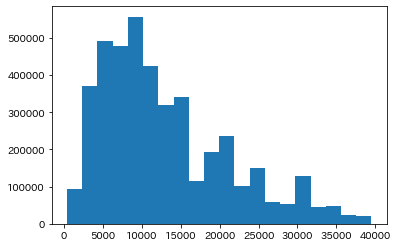

In [10]:
plt.hist(calendar_new['price'], bins=20);

In [11]:
listing.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,35303,https://www.airbnb.com/rooms/35303,20190928054933,2019-09-28,"La Casa Gaienmae C Harajuku, Omotesando is nearby",This shared flat is locating at very close to ...,This apartment is 3 bedroom flat shared with t...,This shared flat is locating at very close to ...,none,10 min walking to Harajuku ~ Urahara ~ Omotesa...,Current tenants are living in this flat over 2...,"5min to subway, 10min to JR stations, you can ...","Your private room, Kitchen, Bathroom, Toilet, ...",I provide common space cleaning twice a week. ...,"If you would like to stay monthly, there is a ...",NaN,NaN,https://a0.muscache.com/im/pictures/67365319/c...,NaN,151977,https://www.airbnb.com/users/show/151977,Miyuki,2010-06-25,"Shibuya, Tokyo, Japan",Hi I am Miyuki Kanda. I run a real estate & pr...,NaN,NaN,NaN,t,https://a0.muscache.com/im/users/151977/profil...,https://a0.muscache.com/im/users/151977/profil...,Shibuya District,3,3,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Shibuya, Tokyo, Japan",Shibuya District,Shibuya Ku,NaN,Shibuya,Tokyo,150-0001,Tokyo,"Shibuya, Japan",JP,Japan,35.67152,139.71203,t,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Paid parking off pr...",NaN,"$4,208.00",NaN,"$110,000.00","$30,000.00","$5,000.00",1,$0.00,28,1125,28,28,1125,1125,28.0,1125.0,11 months ago,t,29,59,89,89,2019-09-28,18,0,2011-12-28,2018-07-28,94.0,9.0,9.0,9.0,10.0,10.0,9.0,t,Other reasons | \n弊社は不動産事業者であり賃貸住宅管理事業者でもあります。...,NaN,f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.19
1,197677,https://www.airbnb.com/rooms/197677,20190928054933,2019-09-28,Oshiage Holiday Apartment,NaN,"We are happy to welcome you to our apartment, ...","We are happy to welcome you to our apartment, ...",none,NaN,NaN,NaN,NaN,NaN,1. Smoking is NOT allowed inside the property....,NaN,NaN,https://a0.muscache.com/im/pictures/38437056/d...,NaN,964081,https://www.airbnb.com/users/show/964081,Yoshimi & Marek,2011-08-13,Tokyo,Would love to travel all over the world and me...,within a day,100%,NaN,t,https://a0.muscache.com/im/users/964081/profil...,https://a0.muscache.com/im/users/964081/profil...,Sumida District,1,1,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Sumida, Tokyo, Japan",Sumida District,Sumida Ku,NaN,Sumida,Tokyo,NaN,Tokyo,"Su

In [12]:
listing["price"] = listing["price"].str.replace("[$, ]", "").astype(float)

In [13]:
# The maximam seems outlier. Therefore, we'll drop outliers. 
# One definition of outlier is any data point more than 1.5 interquartile ranges (IQRs) below the first quartile or above the third quartile.
# Computing IQR
Q1_l = listing['price'].quantile(0.25)
Q3 = listing['price'].quantile(0.75)
IQR = Q3 - Q1

# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
listing = listing.query('(@Q1 - 1.5 * @IQR) <= price <= (@Q3 + 1.5 * @IQR)')

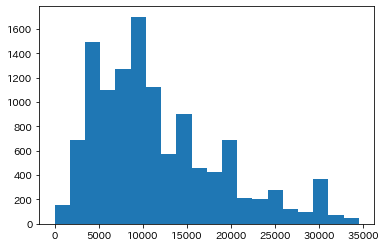

In [14]:
plt.hist(listing['price'], bins=20);

In [15]:
review.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,35303,810980,2011-12-28,1502908,Firuz,Miyuki's has been a great host. Helpful and ve...
1,35303,2467161,2012-10-01,350719,Jordan,Nice apartment in one of the best areas of Tok...
2,35303,3572628,2013-02-18,4917704,Aymeric,A very nice host and place. The location is in...


In [16]:
review.shape[0]

343726

In [17]:
listing["price"].dtype

dtype('float64')

In [18]:
review['listing_id'].nunique() 
#It seems listing_id is foreign key for listing table
#It seems some accomodations did not get reviews yet

10998

In [19]:
review['id'].nunique() #It seems id is a unique number in this table

343726

### Q1: What are the busiest times in the year to visit Tokyo? By how much do prices spike?

In [20]:
# Explore the calendar.csv and find the way
print('The number of available in the calendar is {}'.format(calendar_new[calendar_new['available'] == 't']['available'].count()))
print('The number of not available in the calendar is {}'.format(calendar_new[calendar_new['available'] == 'f']['available'].count()))

The number of available in the calendar is 1717530
The number of not available in the calendar is 2524866


In [21]:
# The duration of calendar data
print('The duration is between {} and {}.'.format(calendar_new['date'].min(), calendar_new['date'].max()))

The duration is between 2019-09-28 and 2020-09-26.


In [22]:
# Create a column that corresponds t/f value in the available column
calendar['available_t'] = calendar['available'].apply(lambda x: 1 if x == 't' else 0)
calendar['available_f'] = calendar['available'].apply(lambda x: 1 if x == 'f' else 0)
calendar['available_total'] = calendar['available'].apply(lambda x: 1 if x == 'f' else 1)

In [23]:
# Change dtype of date column to datetime
calendar['date'] = pd.to_datetime(calendar['date'])

In [24]:
# set index for availability 
df_m = calendar[['available_t','available_f', 'available_total', 'date']].set_index(calendar['date'])
df_m = df_m.set_index([df_m.index.year, df_m.index.month, df_m.index])
df_m.index.names = ['year', 'month', 'date']
df_sum = df_m.sum(level=['year', 'month'])
df_sum['occupancy rate'] = df_m['available_f'].mean(level=['year', 'month'])
df_sum = df_sum.reset_index()

In [25]:
# Create a date column that has the year and the date, e.g.'20XX-XX'
df_sum['year'] = df_sum['year'].astype('str')
df_sum['month'] = df_sum['month'].astype('str')
df_sum['date'] = df_sum['year'].str.cat(df_sum['month'], sep='-')

In [26]:
# set index for price
df_p = calendar[['price','adjusted_price', 'date', 'minimum_nights']].set_index(calendar['date'])
df_p = df_p.set_index([df_p.index.year, df_p.index.month, df_p.index])
df_p.index.names = ['year', 'month', 'date']
df_ave_p = df_p.mean(level=['year', 'month'])
df_ave_p = df_ave_p.reset_index()

In [27]:
df_ave_p

,year,month,price,adjusted_price,minimum_nights
0,2019,9,13970.788030,13831.581333,3.279432
1,2019,10,14805.346960,14761.182163,3.360050
2,2019,11,15564.027933,15566.667633,3.513303
3,2019,12,19172.611644,19205.467516,3.462151
4,2020,1,19652.261091,19672.574154,3.525136
5,2020,2,18792.968825,18781.352527,3.662847
6,2020,3,21917.361506,22026.902952,3.485065
7,2020,4,23827.997197,24009.645096,3.191074
8,2020,5,22858.171444,22902.712762,3.246194
9,2020,6,23517.393573,23526.445529,3.257515


In [28]:
# Create a date column that has the year and the date, e.g.'20XX-XX'
df_ave_p['year'] = df_ave_p['year'].astype('str')
df_ave_p['month'] = df_ave_p['month'].astype('str')
df_ave_p['date'] = df_ave_p['year'].str.cat(df_ave_p['month'], sep='-')

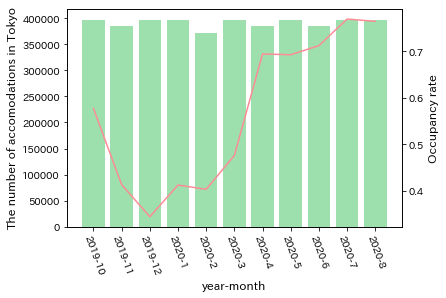

In [29]:
# Create a figure, omitting Sep 2019 and 2020 since some dates are missing
fig, ax1 = plt.subplots()
plt.xticks(rotation=-70)
ax2 = ax1.twinx()
ax1.bar(df_sum['date'].iloc[1:-1], df_sum['available_total'].iloc[1:-1], color="#9DE0AD")
ax2.plot(df_sum['date'].iloc[1:-1], df_sum['occupancy rate'].iloc[1:-1], color="#FF8C94")
ax1.set_xlabel('year-month', fontsize = 12)
ax1.set_ylabel('The number of accomodations in Tokyo', fontsize = 12)
ax2.set_ylabel('Occupancy rate', fontsize = 12);

- The number of accomodation in market does not change drastically over months
- July and August 2020 are the most popular months in this duration
- The The occupancy rate becomes lower around October and November in 2019 and towards 2020 spring season the rate becomes higher

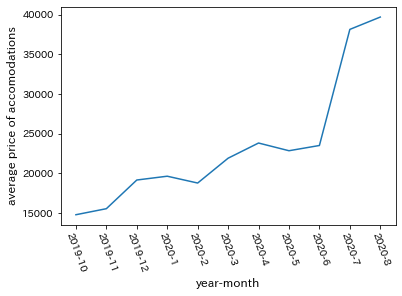

In [30]:
plt.plot(df_ave_p['date'].iloc[1:-1], df_ave_p['price'].iloc[1:-1])
plt.xticks(rotation=-70)
plt.xlabel('year-month', fontsize=12)
plt.ylabel('average price of accomodations', fontsize=12);

- 'price' and 'adjusted_price' columns seem to mean same values
- The price increases during summer time in 2019/2020 and dropps after September 2019

### Q2: What type of rooms is popular? (numbers of beds, etc) Which district is popular?

In [31]:
# numbers of beds -> listing.beds, property type -> listing.property_type,
# room type -> listing.room_type, accommodates -> listing.accommodates,
# Bed type -> listing.bed_type, 
# https://qiita.com/go8/items/90167693f142ebb55a7d (Matplotlib Graph)

In [32]:
# calculate occupancy rate calendar by listing id
df_groupby_ava = calendar.groupby('listing_id')[['available_f', 'available_total']].sum()
df_groupby_ava['occupancy_rate'] = df_groupby_ava.available_f/df_groupby_ava.available_total
df_groupby_ava = df_groupby_ava.reset_index()
# merge this  to listing dataframe
listing_new = pd.merge(listing, df_groupby_ava, how='left', left_on='id', right_on='listing_id')

The maximum number of beds is 50.0
The minimum number of beds is 0.0
The maximum number of accomodates is 16
The minimum number of accomodates is 1
2.0     3857
1.0     3411
3.0     1610
4.0     1196
5.0      544
6.0      417
0.0      260
7.0      192
8.0      190
10.0      88
9.0       86
12.0      42
11.0      28
16.0      17
13.0       8
15.0       6
14.0       5
50.0       5
20.0       3
22.0       2
36.0       2
17.0       1
30.0       1
23.0       1
Name: beds, dtype: int64


/Users/Rory/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Rory/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


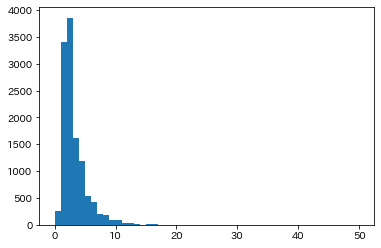

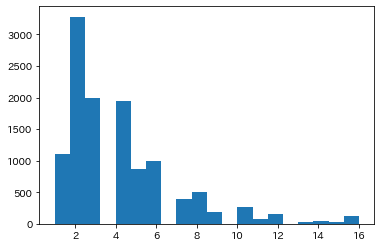

In [33]:
# Histgram of number of beds 
print('The maximum number of beds is {}'.format(listing.beds.max()))
print('The minimum number of beds is {}'.format(listing.beds.min()))
print('The maximum number of accomodates is {}'.format(listing.accommodates.max()))
print('The minimum number of accomodates is {}'.format(listing.accommodates.min()))
print(listing.beds.value_counts())
plt.figure()
plt.hist(listing.beds, bins=50)
plt.figure()
plt.hist(listing.accommodates, bins=20);

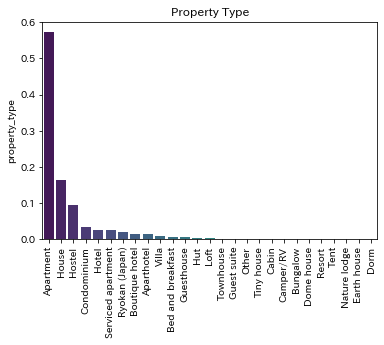

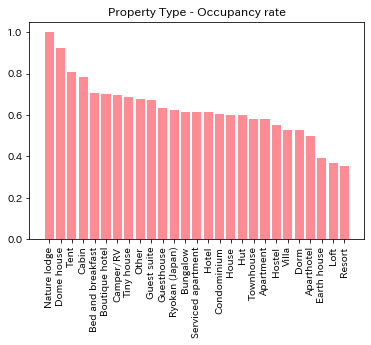

In [34]:
# property type -> listing.property_type
plt.figure()
plt.xticks(rotation=90)
sns.barplot(x=listing_new.property_type.value_counts().index, y=listing_new.property_type.value_counts()/listing.shape[0], palette = 'viridis')
plt.title("Property Type")

# Create a dataframe and sort by occupacy_rate
property_type_oc = pd.DataFrame(listing_new.groupby('property_type').occupancy_rate.mean())
property_type_oc = property_type_oc.sort_values(by=['occupancy_rate'], ascending=False)
plt.figure()
plt.xticks(rotation=90)
plt.bar(property_type_oc.index, property_type_oc.occupancy_rate, color='#FF8C94')
plt.title("Property Type - Occupancy rate");

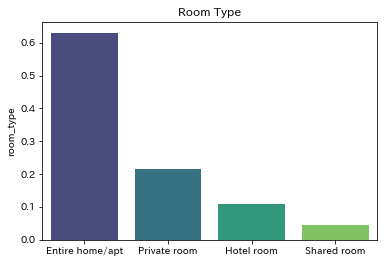

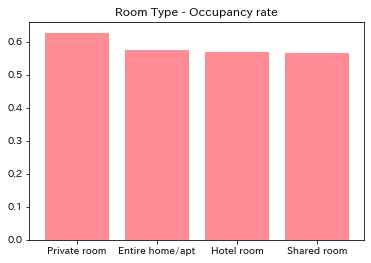

In [35]:
# room type -> listing.room_type
plt.figure()
sns.barplot(listing_new.room_type.value_counts().index, listing_new.room_type.value_counts()/listing.shape[0], palette = 'viridis')
plt.title("Room Type")

# Create a dataframe and sort by occupacy_rate
room_type_oc = pd.DataFrame(listing_new.groupby('room_type').occupancy_rate.mean())
room_type_oc = room_type_oc.sort_values(by=['occupancy_rate'], ascending=False)
plt.figure()
plt.bar(room_type_oc.index, room_type_oc.occupancy_rate, color='#FF8C94')
plt.title("Room Type - Occupancy rate");

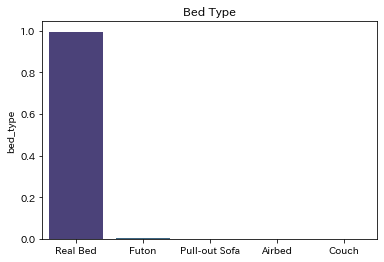

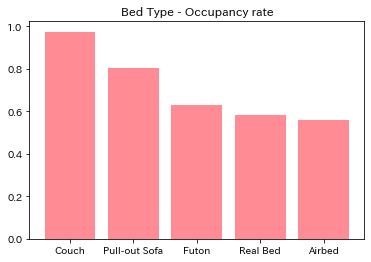

In [36]:
# bed type -> listing.bed_type

plt.figure()
sns.barplot(listing_new.bed_type.value_counts().index, listing_new.bed_type.value_counts()/listing.shape[0], palette = 'viridis')
plt.title("Bed Type")

# Create a dataframe and sort by occupacy_rate
bed_type_oc = pd.DataFrame(listing_new.groupby('bed_type').occupancy_rate.mean())
bed_type_oc = bed_type_oc.sort_values(by=['occupancy_rate'], ascending=False)
plt.figure()
plt.bar(bed_type_oc.index, bed_type_oc.occupancy_rate, color='#FF8C94')
plt.title("Bed Type - Occupancy rate");

In [37]:
listing.bed_type.value_counts()

Real Bed         11920
Futon               50
Pull-out Sofa        6
Airbed               4
Couch                1
Name: bed_type, dtype: int64

### Q3: Which disrict is popular?

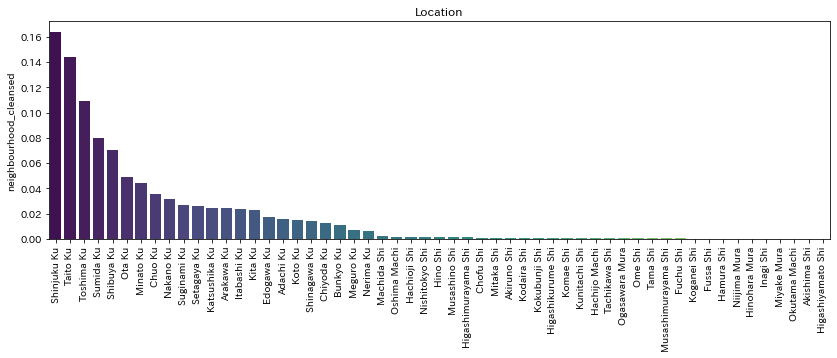

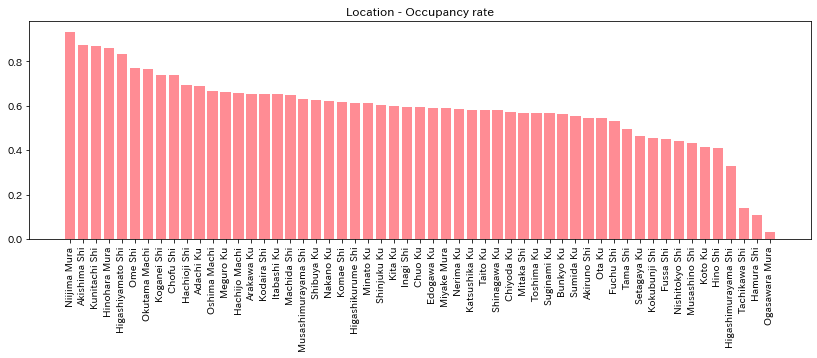

In [38]:
# location -> listing.neighbourhood_cleansed

plt.figure(figsize=(14, 4))
plt.xticks(rotation=90)
sns.barplot(listing_new.neighbourhood_cleansed.value_counts().index,listing_new.neighbourhood_cleansed.value_counts()/listing.shape[0], palette = 'viridis')
plt.title("Location")

# Create a dataframe and sort by occupacy_rate
neighbourhood_cleansed_oc = pd.DataFrame(listing_new.groupby('neighbourhood_cleansed').occupancy_rate.mean())
neighbourhood_cleansed_oc = neighbourhood_cleansed_oc.sort_values(by=['occupancy_rate'], ascending=False)
plt.figure(figsize=(14, 4))
plt.xticks(rotation=90)
plt.bar(neighbourhood_cleansed_oc.index, neighbourhood_cleansed_oc.occupancy_rate, color='#FF8C94')
plt.title("Location - Occupancy rate");

### Q4: What price is the average price per person?

In [39]:
listing['price_pp'] = listing.price/listing.accommodates
print('The average price per person is {} yen.'.format(round(listing['price_pp'].mean())))

The average price per person is 3396 yen.


### Q5: Can we predict prices by other parameters?

In [40]:
listing = listing.rename(index=str, columns={"id": "listing_id"})

In [41]:
# We'll merge listing dataframe and 'month' in calendar dataframe
# Create a column that holds month data in calendar dataframe
calendar['month'] = calendar.date.dt.month
calendar_new = calendar.drop(['date','available','adjusted_price','price'], axis=1)
listing_new = listing.drop(['minimum_nights','maximum_nights'], axis=1)

# Merge calendar and listing data onmerge
df_new = pd.merge(calendar_new, listing_new, on = 'listing_id')

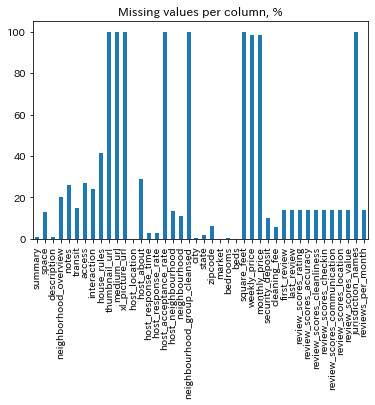

In [42]:
# Check missing values
listings_missing_df = df_new.isnull().mean()*100

#filter out only columns, which have missing values
listings_columns_with_nan = listings_missing_df[listings_missing_df > 0]

#plot the results
listings_columns_with_nan.plot.bar(title='Missing values per column, %');

In [43]:
'''Drop columns that have high null ratio:
    thumbnail_url, medium_url, xl_picture_url, host_acceptance_rate, neighbourhood_group_cleansed, 
   square_feet, weekly_price, monthly_price, jurisdiction_names

   Drop other unneeded columns:
   from calendar dataframe: date, available, adjusted_price, minimum_nights, maximum_nights
   from listing dataframe: host_since, id, listing_url, scrape_id, last_scraped, name, summary, space, 
   description, experiences_offered, neighborhood_overview, notes, 
   transit, access, interaction, house_rules, thumbnail_url, medium_url, 
   picture_url, xl_picture_url, host_id, host_url, host_name, host_location, 
   host_about, host_thumbnail_url, host_picture_url, host_neighbourhood, host_verifications, 
   host_has_profile_pic, host_identity_verified, smart_location, state, city, zipcode, market, country_code, country, 
   latitude, longitude, is_location_exact, amenities, calendar_updated, calendar_last_scraped, 
   first_review, last_review, license, cancellation_policy, require_guest_profile_picture, 
   require_guest_phone_verification, price_pp,calculated_host_listings_count,
   minimum_minimum_nights, maximum_minimum_nights, minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm,
   calculated_host_listings_count_entire_homes, calculated_host_listings_count_private_rooms, calculated_host_listings_count_shared_rooms'''

columns_to_drop = ['host_since','thumbnail_url','medium_url','xl_picture_url','host_acceptance_rate','neighbourhood_group_cleansed',
'square_feet','weekly_price','monthly_price','jurisdiction_names','listing_id','listing_url','scrape_id','last_scraped','name','summary','space',
'description','experiences_offered','neighborhood_overview','notes','transit','access','interaction','house_rules','thumbnail_url','medium_url',
'picture_url','xl_picture_url','host_id','host_url','host_name','host_location','host_about','host_thumbnail_url',
'host_picture_url','neighbourhood','street','host_neighbourhood','host_verifications','smart_location','state','city',
'zipcode','market','country_code','country','latitude','longitude','is_location_exact','amenities','calendar_updated',
'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm',
'calendar_last_scraped','first_review','last_review','license','cancellation_policy','require_guest_profile_picture',
'require_guest_phone_verification','price_pp','calculated_host_listings_count','calculated_host_listings_count_entire_homes',
'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms']

In [44]:
df_new_clean = df_new.drop(columns_to_drop, axis=1)

In [45]:
# 1 dropping all the rows that have missing data
df_new_clean.dropna(inplace=True)

In [46]:
df_new_clean.month.dtype

dtype('int64')

In [47]:
# Categorical variables -> host_response_time, host_is_superhost, host_has_profile_pic, host_identity_verified, neighbourhood_cleansed, 
# property_type, room_type, bed_type, has_availability, instant_bookable, is_business_travel_ready, 

# Numerical variables -> host_response_rate, host_listings_count, host_total_listings_count, accommodates, bathrooms, 
# bedrooms, beds, security_deposit, cleaning_fee, guests_included, minimum_nights, maximum_nights, availability_30, 
# availability_60, availability_90, availability_365, number_of_reviews, number_of_reviews_ltm, review_scores_rating, 
# review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, 
# review_scores_value, reviews_per_month

# Change 'object' datatype to numeric -> host_response_rate, security_deposit, cleaning_fee, extra_people
df_new_clean["host_response_rate"] = df_new_clean["host_response_rate"].str.replace("%", "")
df_new_clean["security_deposit"] = df_new_clean["security_deposit"].str.replace("[$, ]", "")
df_new_clean["cleaning_fee"] = df_new_clean["cleaning_fee"].str.replace("[$, ]", "")
df_new_clean["extra_people"] = df_new_clean["extra_people"].str.replace("[$, ]", "")
df_new_clean = df_new_clean.astype({'host_response_rate': float, 'security_deposit': float, 'cleaning_fee': float, 'extra_people': float})

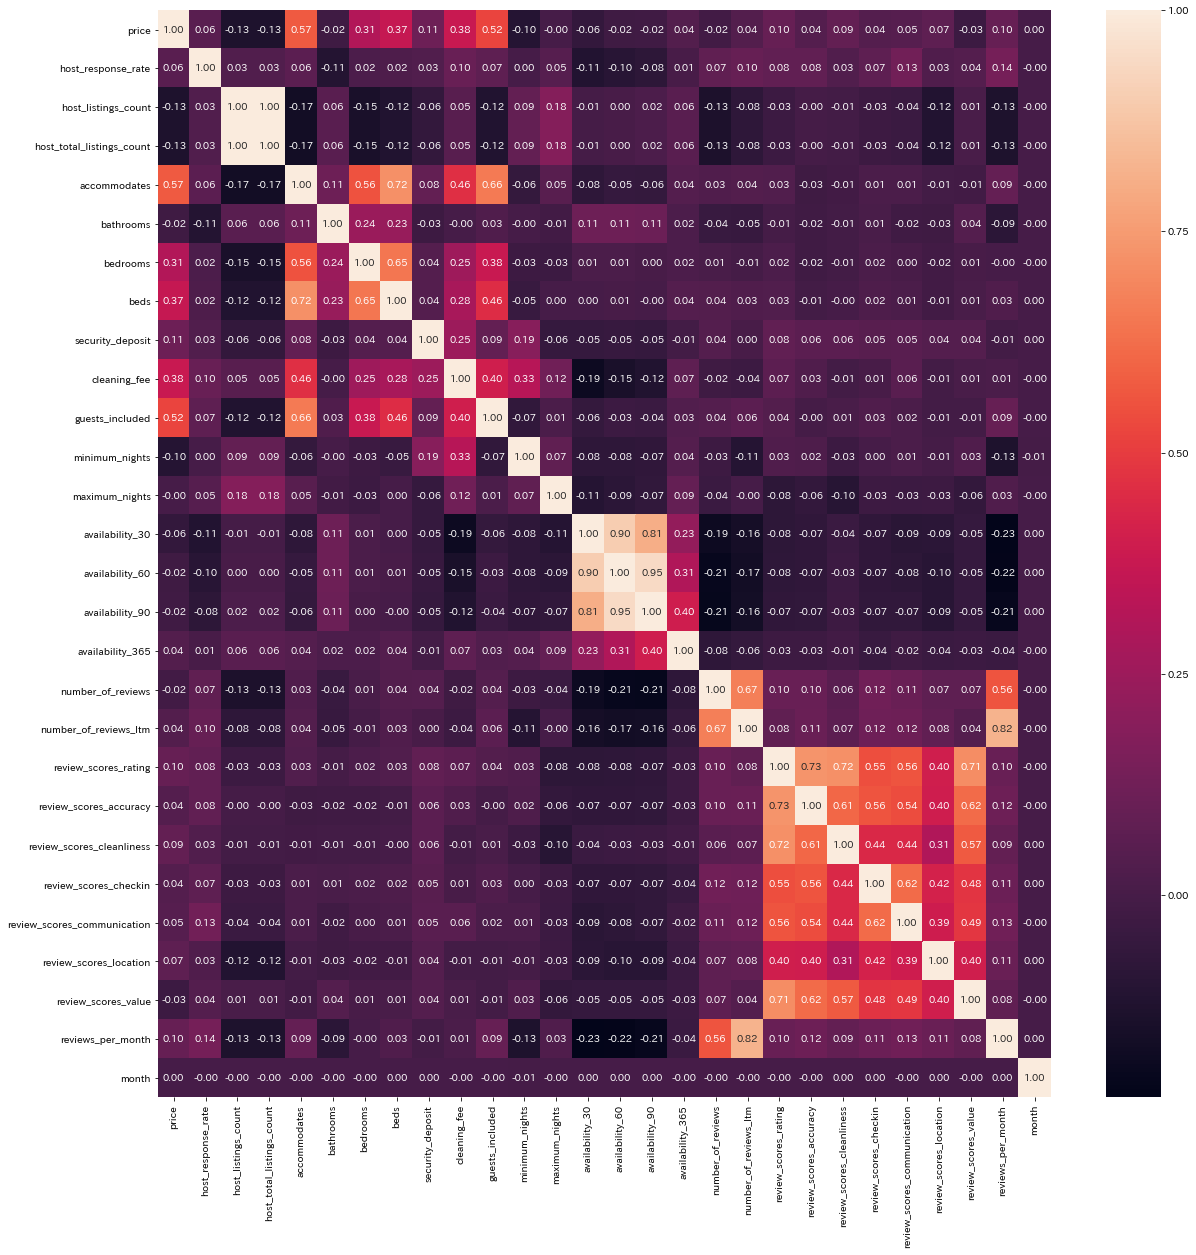

In [48]:
# numerical variables to find out the correlations
cols = ['price', 'host_response_rate','host_listings_count','host_total_listings_count','accommodates','bathrooms',
        'bedrooms', 'beds', 'security_deposit','cleaning_fee','guests_included','minimum_nights',
        'maximum_nights','availability_30', 'availability_60','availability_90','availability_365',
        'number_of_reviews','number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy',
        'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication', 'review_scores_location',
        'review_scores_value', 'reviews_per_month', 'month']
plt.figure(figsize=(20,20))
sns.heatmap(df_new_clean[cols].corr(), annot=True, fmt='.2f');

In [56]:
#Pull a list of the column names of the categorical variables
cat_df = df_new_clean.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns

In [57]:
# Convert Categorical variables
def create_dummy_df(df, cat_cols, dummy_na):
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

df_new_clean_cat = create_dummy_df(df_new_clean, cat_cols_lst, dummy_na=False)

In [58]:
# Train ML model by only numerical columns, by LinearRegression
X = df_new_clean_cat.drop('price', axis=1)
y = df_new_clean[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=30)

In [59]:
# Train ML model by only numerical columns, with RandomForest
forest = RandomForestRegressor(n_estimators=4, 
                               criterion='mse', 
                               random_state=57, 
                               n_jobs=-1)
forest = forest.fit(X_train, y_train.squeeze())

#calculate scores for the model
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

Random Forest MSE train: 77.165, test: 294.628
Random Forest R^2 train: 1.000, test: 1.000


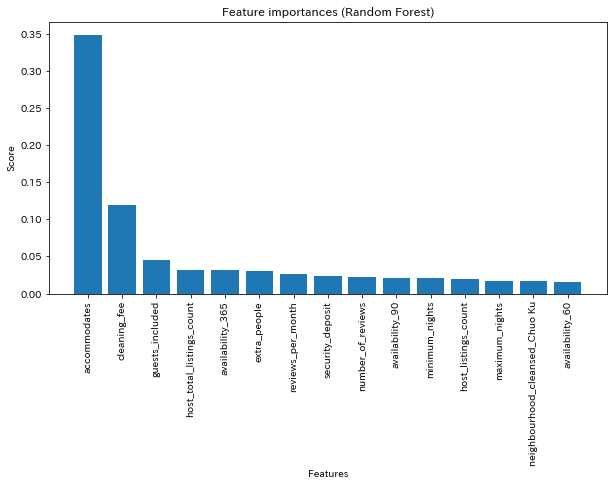

In [60]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, forest.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:15]

#plot feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center')
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (Random Forest)')
 
plt.show()

In [61]:
# create a dataframe that has actual data and predicted data
DFRFtest = pd.DataFrame({'Actual':y_test['price'], 'Prediction': y_test_pred})

# check the first 5 data
DFRFtest.head(5)

,Actual,Prediction
3101124,11977.0,11977.0
3777057,19962.0,19962.0
3647870,11977.0,11977.0
4054395,8848.0,8848.0
2644284,10035.0,10035.0
